In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import re
import pickle
import sklearn
import pandas as pd
import numpy as np
# import holoviews as hv
# import hvplot
import nltk                                 #the [Natural Language Toolkit (NLTK)]
# from bokeh.io import output_notebook
# output_notebook()

# from hvplot import pandas
from pathlib import Path
#hv.extension("bokeh")

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')    
import matplotlib.pyplot as plt            # library for visualization
import random                              # pseudo-random number generator
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
pip install pyarrow

In [4]:
data_treatmeants = pd.read_excel('keywords_psoriasis_therapies.xlsx')
data_treatmeants['keyword'] = data_treatmeants['keyword'].apply(lambda x: x.lower())
data_treatmeants['category'] = data_treatmeants['category'].apply(lambda x: x.lower())
data_treatmeants

,keyword,category
0,apremilast,andere systemische therapie
1,phosphodiesterase-hemmer,andere systemische therapie
2,otezla,andere systemische therapie
3,pde4,andere systemische therapie
4,inhibitor,andere systemische therapie
5,pde4-inhibitor,andere systemische therapie
6,ciclosporin,andere systemische therapie
7,cicloral,andere systemische therapie
8,immunosporin,andere systemische therapie
9,fumarsäureester,andere systemische therapie


In [5]:
from pathlib import Path

import pyarrow.parquet as pq

data = pq.read_table('psoriasis_all_posts.parquet').to_pandas()
data = data[['text', 'forum_id']]
data.reset_index(drop=True, inplace=True)

data_treatmeants = pd.read_excel('keywords_psoriasis_therapies.xlsx')


dict_medical = dict(data_treatmeants.values)
data['text'] = data['text'].apply(lambda x: x.lower()).replace(dict_medical, regex=True)

data.head()

,text,forum_id
0,zunehmend oft höre ich über die problematik der schuppenflechte auch von bekanten und freunden;...,4-community
1,"hallo annamaria, herzlich willkommen hier im forum fühle dich wohl hier.lese dich ein wenig e...",4-community
2,"hallo, annamaria - ich wünsche dir wirklich dauerhafte besserung und wenn es schlimmer werden ...",4-community
3,auch ich wünsche euch ein schönes und glückliches jahr 2010! quote,1-allgemeines
4,ich wünsche allen frohes neues jahr gb pics quote,1-allgemeines


In [6]:
data.shape

(55888, 2)

In [7]:
data['forum_id'].unique()

array(['4-community', '1-allgemeines', '2-behandlung',
       '3-klinik-reha-kur-urlaub'], dtype=object)

In [8]:
data['forum_id'].nunique()

4

Checking for null values.

In [9]:
pd.isnull(data['forum_id']).sum()

0

No null values are present.

In [10]:
data['text'].apply(lambda x: len(x.split(' '))).sum()

7137722

We have more than 7 million words in the data.

Distribution of classes.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


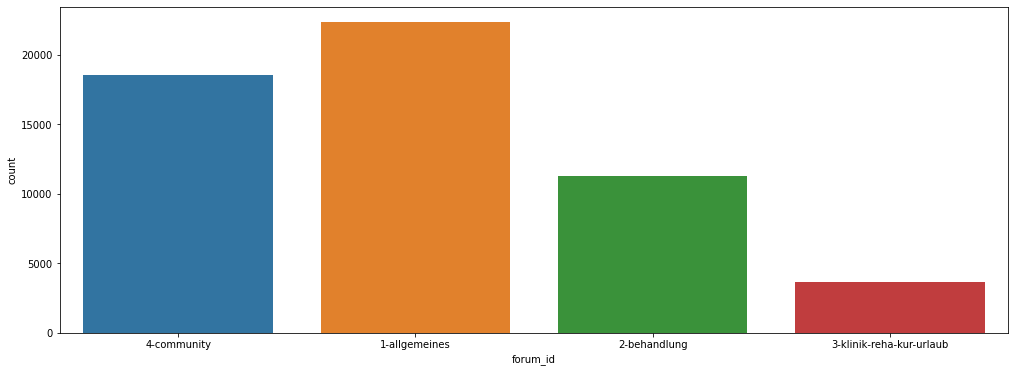

In [11]:
plt.figure(figsize=(17,6))
sns.countplot(data['forum_id'])

From the above visualisation we can see classes are very well balanced.

In [12]:
def post_tag(index):
    post = data[data.index==index].values[0]
    print(post[0])
    print('forum_id:', post[1])

Looking few posts and tags.

In [13]:
post_tag(5)

 guck dir den guy bloss an, dem trau ich alles zu,   na na junge frau  was soll das denn heissen:altes-lachen:überlegen::zwinker-alt:  glg  guy:p:p              quote      
forum_id: 1-allgemeines


In [14]:
post_tag(11)

 hallo ihr lieben,  klar mag ich märchen und deshalb hab ich mir die verfilmungen auch angesehen. ich fand sie wirklich gut gemacht. natürlich kenn ich auch die alten verfilmungen, sowohl die deutschen als auch die tschechischen.  liebe grüße und ein frohes neues jahr  bella                      quote      
forum_id: 4-community


In [15]:
post_tag(10000)

 hallo zusammen, ich  bin die neue, und komme  jetzt öfter...^^.  ich  mag mich hier mal umschauen, und will mal querlesen, wie eure erfahrung mit  der 	pso  so sind.  ich  trage sie seit  ca.6 jahren mit mir rum, anfangs wars so  heftig, das  ich richtig tiefe  löcher  an den ellenbogen und  kneien  hatte,sehr schmerzhafte  angelegenheit damals.  heute schwankt die stärke  der flechte sehr,bei stress kann es innerhalb von  ein - zwei stunden so schlimm werden, das es blutet.  ich bin  vor  anderthalb jahren  nocheinmal mama geworden, und stellte mit grosser freude  fest, das  die gesamten  stellen  abheilten, und  auch nichts  neues nachkam. direkt nach der geburt gings aber wieder los, und  so ist es  leider bis heute.  ich habe ehrlich gesagt nicht mal  eine 			ahnung, welche form ich  habe, ich vermute es ist vulgaris, aber da muss ich noch mal genauer nachforschen.  bislang habe ich  von meinem  arzt (hausarzt)  immer  dermoxin  verschrieben bekommen, und  diese  bei bedarf einges

The texts needs to be cleaned up.

In [16]:
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
data['text'] = data['text'].apply(clean_text)

In [20]:
post_tag(5)

guck guy bloss trau na na jung frau heiss alt lach uberleg zwink alt glg guy quot
forum_id: 1-allgemeines


In [21]:
post_tag(11)

hallo lieb klar mag march deshalb verfilm angeseh fand wirklich gut gemacht natur kenn alt verfilm sowohl deutsch tschechisch lieb gruss froh neu jahr bella quot
forum_id: 4-community


In [22]:
post_tag(10000)

hallo zusamm neu komm oft mag mal umschau mal querles erfahr pso trag seit ca jahr rum anfang war heftig richtig tief loch ellenbog kneien schmerzhaft angeleg damal heut schwankt stark flecht stress innerhalb zwei stund schlimm blutet anderthalb jahr nocheinmal mama geword stellt gross freud fest gesamt stell abheilt neu nachkam direkt geburt ging los leid heut ehrlich gesagt mal ahnung form vermut vulgaris mal genau nachforsch bislang arzt hausarzt imm dermoxin verschrieb bekomm bedarf eingesetzt weit schritt unternomm jedoch and ganz aktiv angeh mehr motto halt hinnehm edited january by beefi quot
forum_id: 4-community


In [23]:
data['text'].apply(lambda x: len(x.split(" "))).sum()

2780101

Much better.

Now, we have over 2.7 million words to work with.

Splitting the dataset.

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = data['text']
y = data['forum_id']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [27]:
X_train.shape

(44710,)

In [28]:
X_test.shape

(11178,)

In [29]:
X_test.head()

41490    hallo jp vielleicht braucht steffi moral geseh eierlikor schokobech lieb steffi stell john paul ...
24690    tap heilpraktikerin gemacht darauf spezialisiert ruck hal farb pink erklart tap durchblut angere...
32494    hallo skyla sag hallo neu diagnos donnerstag bekomm les gerad thread nie gedank gemacht kopf ell...
50184    hallo jasminka lies mal link steht schon mal wesent unterschied drin einzig fehlt psoriasis uber...
8757     hey ja bluttupf gluck steh meist fruh nacht uhr wach geword kratz aufgestand ne halb stund bad g...
Name: text, dtype: object

The next steps includes feature engineering and model building using pipeline.

# Naive Bayes classifier for multinomial models.

In [30]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [31]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [33]:
y_pred = nb.predict(X_test)

In [34]:
print(confusion_matrix(y_pred,y_test))

[[4092 1856  601 1905]
 [  28  237    0   21]
 [   0    0    6    0]
 [ 323  215  168 1726]]


In [35]:
print(classification_report(y_pred, y_test,target_names=data['forum_id'].unique()))
print(accuracy_score(y_pred,y_test))

                          precision    recall  f1-score   support

             4-community       0.92      0.48      0.63      8454
           1-allgemeines       0.10      0.83      0.18       286
            2-behandlung       0.01      1.00      0.02         6
3-klinik-reha-kur-urlaub       0.47      0.71      0.57      2432

                accuracy                           0.54     11178
               macro avg       0.38      0.76      0.35     11178
            weighted avg       0.80      0.54      0.61     11178

0.542225800679907


# Linear support vector machine.

In [36]:
from sklearn.linear_model import SGDClassifier

In [37]:
svm = Pipeline([('vect',CountVectorizer()),
               ('tfidf',TfidfTransformer()),
               ('svm_clf', SGDClassifier(loss='hinge', penalty='l2',alpha=0.001,n_jobs=-1,random_state=0,max_iter=5))])
svm.fit(X_train,y_train)             

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('svm_clf',
                 SGDClassifier(alpha=0.001, max_iter=5, n_jobs=-1,
                               random_state=0))])

In [38]:
%%time
y_pred_svm = svm.predict(X_test)
print(accuracy_score(y_test,y_pred_svm))
print(classification_report(y_test,y_pred_svm, target_names=data['forum_id'].unique()))

0.596886741814278
                          precision    recall  f1-score   support

             4-community       0.56      0.77      0.65      4443
           1-allgemeines       0.70      0.31      0.43      2308
            2-behandlung       0.73      0.47      0.58       775
3-klinik-reha-kur-urlaub       0.61      0.59      0.60      3652

                accuracy                           0.60     11178
               macro avg       0.65      0.54      0.56     11178
            weighted avg       0.62      0.60      0.58     11178

CPU times: user 773 ms, sys: 4.99 ms, total: 778 ms
Wall time: 775 ms


# Logistic regression.

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
lr = Pipeline([('vect',CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('lr_clf', LogisticRegression(n_jobs=-1,C=0.01))])

In [41]:
lr.fit(X_train,y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('lr_clf', LogisticRegression(C=0.01, n_jobs=-1))])

In [42]:
y_pred_lr = lr.predict(X_test)

In [43]:
print(accuracy_score(y_pred_lr,y_test))
print(classification_report(y_pred_lr,y_test,target_names= data['forum_id'].unique()))

0.47566648774378245
                          precision    recall  f1-score   support

             4-community       0.92      0.44      0.59      9340
           1-allgemeines       0.00      1.00      0.00         1
            2-behandlung       0.00      0.00      0.00         0
3-klinik-reha-kur-urlaub       0.33      0.67      0.45      1837

                accuracy                           0.48     11178
               macro avg       0.31      0.53      0.26     11178
            weighted avg       0.82      0.48      0.57     11178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest.

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rfc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('rfc', RandomForestClassifier(n_estimators=200, criterion='entropy'))])
rfc.fit(X_train,y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('rfc',
                 RandomForestClassifier(criterion='entropy',
                                        n_estimators=200))])

In [46]:
y_pred_rfc = rfc.predict(X_test)

In [47]:
print(accuracy_score(y_pred_rfc,y_test))
print(classification_report(y_pred_rfc,y_test))

0.5977813562354625
                          precision    recall  f1-score   support

           1-allgemeines       0.82      0.54      0.65      6708
            2-behandlung       0.27      0.75      0.39       824
3-klinik-reha-kur-urlaub       0.38      0.83      0.52       349
             4-community       0.59      0.65      0.62      3297

                accuracy                           0.60     11178
               macro avg       0.51      0.69      0.54     11178
            weighted avg       0.70      0.60      0.62     11178



# Creating bag of words with Keras.

In [48]:
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing import text, sequence

In [49]:
train_size = int(len(data) * 0.8)

In [50]:
print('Train size: %d' %train_size)
print('Test_size: %d' %(len(data)-train_size))

Train size: 44710
Test_size: 11178


In [51]:
train_post = data['text'][:train_size]
train_tag = data['forum_id'][:train_size]
test_post = data['text'][train_size:]
test_tag = data['forum_id'][train_size:]

In [52]:
train_post.head()

0    zunehm oft hor problemat schuppenflecht bekant freund fing freien tag informi forum gestoss eig ...
1             hallo annamaria herzlich willkomm forum fuhl wohl les wenig frag hast drauf los klaus quot
2    hallo annamaria wunsch wirklich dauerhaft besser schlimm sollt gut dermatolog such schon toll fo...
3                                                                       wunsch schon glucklich jahr quot
4                                                                      wunsch froh neu jahr gb pics quot
Name: text, dtype: object

In [53]:
train_tag.value_counts()

1-allgemeines               18286
4-community                 15110
2-behandlung                 8004
3-klinik-reha-kur-urlaub     3310
Name: forum_id, dtype: int64

In [54]:
test_post.head()

44710    schrieb gangstabean bereit hautarzt frankfurt angeruf entwed zurzeit aufnahmestopp telefon gefra...
44711    crem verschrieb bekomm meist kortison kortison mehr arm irgendwann imm aufgeriss wurd insgesamt ...
44712    hallo gangstabeanss uni frankfurt grund genannt warum medikament verschreib uni erlang ambulanz ...
44713    wunderchon gut morg lieb leidensgenoss uberschrift bereit entnehm zurzeit probl arzt weig beispi...
44714    hallo gangstabeanss weist uberhaupt teu taltz weist hoch budget arzt versteh schreib einfach arz...
Name: text, dtype: object

In [55]:
test_tag.head()

44710    1-allgemeines
44711    1-allgemeines
44712    1-allgemeines
44713    1-allgemeines
44714    1-allgemeines
Name: forum_id, dtype: object

In [56]:
token = text.Tokenizer(num_words=1000,char_level=False)

In [57]:
token.fit_on_texts(train_post)

In [58]:
x_train = token.texts_to_matrix(train_post)
x_test = token.texts_to_matrix(test_post)

In [59]:
print(x_train)
print(x_train.shape)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(44710, 1000)


In [60]:
print(x_test)
print(x_test.shape)

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(11178, 1000)


In [61]:
from sklearn.preprocessing import LabelEncoder

In [62]:
encoder = LabelEncoder()

In [63]:
Y_train = encoder.fit_transform(train_tag)
Y_test = encoder.transform(test_tag)

In [64]:
print(Y_train)
print(Y_train.shape)

[3 3 3 ... 0 0 0]
(44710,)


In [65]:
print(Y_test)
print(Y_test.shape)

[0 0 0 ... 0 0 0]
(11178,)


In [66]:
num_classes = np.max(Y_train) + 1

In [67]:
from tensorflow.keras import utils as np_utils


Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

In [68]:
print(Y_test)
print(Y_test.shape)
print(Y_train)
print(Y_train.shape)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
(11178, 4)
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
(44710, 4)


Building model.

In [69]:
model = Sequential()
model.add(Dense(512, input_shape=(1000,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [70]:
%%time
history = model.fit(x_train,Y_train, batch_size=32, epochs=20, validation_data=(x_test, Y_test))



Epoch 1/20
1398/1398 [==============================] - 9s 5ms/step - loss: 1.0281 - accuracy: 0.5397 - val_loss: 1.0417 - val_accuracy: 0.5245
Epoch 2/20
1398/1398 [==============================] - 7s 5ms/step - loss: 0.9127 - accuracy: 0.6017 - val_loss: 1.0334 - val_accuracy: 0.5197
Epoch 3/20
1398/1398 [==============================] - 7s 5ms/step - loss: 0.8205 - accuracy: 0.6482 - val_loss: 1.0331 - val_accuracy: 0.5492
Epoch 4/20
1398/1398 [==============================] - 7s 5ms/step - loss: 0.7152 - accuracy: 0.6996 - val_loss: 1.0899 - val_accuracy: 0.5428
Epoch 5/20
1398/1398 [==============================] - 7s 5ms/step - loss: 0.6066 - accuracy: 0.7532 - val_loss: 1.2100 - val_accuracy: 0.5337
Epoch 6/20
1398/1398 [==============================] - 6s 5ms/step - loss: 0.5171 - accuracy: 0.7928 - val_loss: 1.3047 - val_accuracy: 0.5311
Epoch 7/20
1398/1398 [==============================] - 7s 5ms/step - loss: 0.4481 - accuracy: 0.8236 - val_loss: 1.3985 - val_accuracy:

In [71]:
score = model.evaluate(x_test, Y_test,
                       batch_size=32, verbose=1)
print('Test accuracy:', score[1])

350/350 [==============================] - 1s 3ms/step - loss: 2.1955 - accuracy: 0.5278
Test accuracy: 0.5278224945068359


In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

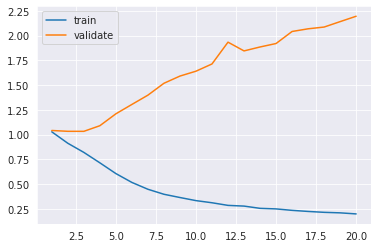

In [73]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="validate")
plt.legend()
plt.show()

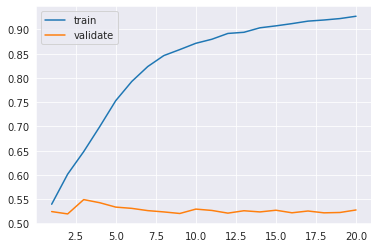

In [74]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="validate")
plt.legend()
plt.show()

## **Transfer learning using transformers (German Bert):**

In [75]:
pip install transformers

     |████████████████████████████████| 3.1 MB 4.1 MB/s 
     |████████████████████████████████| 3.3 MB 41.0 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
     |████████████████████████████████| 895 kB 40.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [76]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

In [77]:
df = data.copy()

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55888 entries, 0 to 55887
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      55888 non-null  object
 1   forum_id  55888 non-null  object
dtypes: object(2)
memory usage: 873.4+ KB


# Data preparation
Spliting the data into train and test sets

In [79]:
X = df['text']
y = df['forum_id']

In [80]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [81]:
encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# German BERT model

## Stats
In addition to the recently released German BERT model by deepset we provide another German-language model.

The source data for the model consists of a recent Wikipedia dump, EU Bookshop corpus, Open Subtitles, CommonCrawl, ParaCrawl and News Crawl. This results in a dataset with a size of 16GB and 2,350,234,427 tokens.

For sentence splitting, we use spacy. Our preprocessing steps (sentence piece model for vocab generation) follow those used for training SciBERT. The model is trained with an initial sequence length of 512 subwords and was performed for 1.5M steps.

This release includes both cased and uncased models.

In [111]:
# Creating tokenizer

from transformers import AutoModel, AutoTokenizer

# Creating tokenizer
tokenizer = AutoTokenizer.from_pretrained('dbmdz/bert-base-german-cased')
bert = TFAutoModel.from_pretrained('dbmdz/bert-base-german-cased')

Some layers from the model checkpoint at dbmdz/bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [112]:
for layer in bert.layers:
      layer.trainable = True

The function which allows to encode our dataset with tokenizer. We have decided on a maximum sentence length is 100 (maxlen).

In [113]:
# Tokenization of the data
def text_encode(text, tokenizer, max_len=100):
    tokens = text.apply(lambda x: tokenizer(x,return_tensors='tf', 
                                            truncation=True,
                                            padding='max_length',
                                            max_length=max_len, 
                                            add_special_tokens=True))
    input_ids= []
    attention_mask=[]
    for item in tokens:
        input_ids.append(item['input_ids'])
        attention_mask.append(item['attention_mask'])
    input_ids, attention_mask=np.squeeze(input_ids), np.squeeze(attention_mask)

    return [input_ids,attention_mask]

Based on this encodings for our training and testing datasets are generated as follows:

In [114]:
X_train_input_ids, X_train_attention_mask = text_encode(X_train, tokenizer, max_len=100)
X_test_input_ids, X_test_attention_mask = text_encode(X_test, tokenizer, max_len=100)

# **Build the model**
We create a Distilbert model with pretrained weights and then we add two Dense layers with Dropout layer.

In [115]:
# model creation
def build_model(bert_model, maxlen=100):
   input_ids = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='input_ids')
   attention_mask = tf.keras.Input(shape=(maxlen,),dtype=tf.int32, name='attention_mask')

   sequence_output = bert_model(input_ids,attention_mask=attention_mask)
   output = sequence_output[0][:,0,:]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(4,activation='softmax')(output)

   model = tf.keras.models.Model(inputs = [input_ids,attention_mask], outputs = [output])
   model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

   return model

In [116]:
model = build_model(bert, maxlen=100)

In [ ]:
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    batch_size=32,
    validation_data=([X_test_input_ids, X_test_attention_mask], y_test),
    epochs=10)

Epoch 1/10
1398/1398 [==============================] - 722s 505ms/step - loss: 1.4124 - accuracy: 0.3550 - val_loss: 1.2527 - val_accuracy: 0.3886
Epoch 2/10
1398/1398 [==============================] - 699s 500ms/step - loss: 1.2826 - accuracy: 0.3789 - val_loss: 1.2437 - val_accuracy: 0.3817
Epoch 3/10
1398/1398 [==============================] - 694s 497ms/step - loss: 1.2637 - accuracy: 0.3826 - val_loss: 1.2403 - val_accuracy: 0.3847
Epoch 4/10
1193/1398 [========================>.....] - ETA: 1:22 - loss: 1.2557 - accuracy: 0.3845

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Predictions on a test set:

In [ ]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_mask], y_test)
print('Test accuracy :', accuracy)

# **Summary**
For our analysis we have used a pretrained Distilbert model to resolve our text classification problem. After trained model we achieved an accuracy on the test set equal to 93 % and it is a similar result in comparison to previous models that we have used. We also tested a several models by adding layers and increase numbers of epochs but we didn't achieve a better accuracy.

In [ ]:
!pip3 freeze > requirements.txt  # Python3